# Leyes de Potencia en Hipnogramas del Sueño

Este notebook implementa el análisis solicitado para verificar si las distribuciones de **n-gramas** de hipnogramas siguen leyes de potencia (tipo Zipf). Trabajaremos tanto a nivel individual (un paciente) como de manera consolidada (todos los pacientes con archivos **_2**). Los pasos principales son:

- Cargar hipnogramas (columna **scor_quasi**, validación manual)
- Generar **n-gramas** y calcular frecuencias marginales
- Ordenar por rango y transformar a escala log-log
- Ajustar regresiones lineales para estimar exponentes y bondad de ajuste
- Visualizar resultados y resumir métricas clave


## 1. Importaciones y configuración

In [45]:
import os
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

RUTA_DATOS = Path("../Datos")
ETIQUETAS_ETAPAS = {
    0: "Vigilia (W)",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "N4",
    5: "REM",
    6: "Movimiento",
    7: "Sin clasificar"
}

## 2. Funciones base

In [ ]:
def listar_pacientes(ruta_datos=None):
    """Devuelve identificadores de pacientes con archivos `_2`."""
    if ruta_datos is None:
        ruta_datos = RUTA_DATOS
    archivos = []
    for archivo in ruta_datos.iterdir():
        if archivo.name.startswith("Scoring_") and archivo.name.endswith("_2") and archivo.is_file():
            archivos.append(archivo.name.replace("Scoring_", ""))
    return sorted(archivos)


def cargar_hipnograma(paciente, ruta_datos=None):
    """Carga hipnograma (columna `scor_quasi`) y retorna lista de etapas."""
    if ruta_datos is None:
        ruta_datos = RUTA_DATOS
    ruta_archivo = ruta_datos / f"Scoring_{paciente}"
    if not ruta_archivo.exists():
        raise FileNotFoundError(f"No se encontró el archivo: {ruta_archivo}")
    df = pd.read_csv(ruta_archivo, sep=r"\s+", header=None, names=["epoca", "scor_clean", "scor_quasi"])
    return df["scor_clean"].astype(int).tolist()


def generar_ngramas(secuencia, n):
    """Genera n-gramas como tuplas de enteros."""
    if n <= 0:
        raise ValueError("El tamaño n debe ser positivo")
    if len(secuencia) < n:
        return []
    ngramas = []
    for i in range(len(secuencia) - n + 1):
        ngramas.append(tuple(secuencia[i:i + n]))
    return ngramas


def representar_simbolo(simbolo):
    """Convierte un n-grama en cadena legible."""
    if len(simbolo) == 1:
        etapa = simbolo[0]
        nombre = ETIQUETAS_ETAPAS.get(etapa, f"Etapa {etapa}")
        return f"{etapa} ({nombre})"
    return "→".join(str(valor) for valor in simbolo)


def construir_dataframe_frecuencias(contador, n):
    """Construye DataFrame ordenado por frecuencia con columnas logarítmicas."""
    if not contador:
        columnas = ["Símbolo", "Representación", "Frecuencia", "Probabilidad", "Rango", "log10(Rango)", "log10(Frecuencia)", "n"]
        return pd.DataFrame(columns=columnas)

    total = sum(contador.values())
    filas = []
    for rango, (simbolo, frecuencia) in enumerate(contador.most_common(), start=1):
        filas.append({
            "Símbolo": simbolo,
            "Representación": representar_simbolo(simbolo),
            "Frecuencia": frecuencia,
            "Probabilidad": frecuencia / total,
            "Rango": rango,
            "log10(Rango)": np.log10(rango),
            "log10(Frecuencia)": np.log10(frecuencia),
            "n": n
        })
    return pd.DataFrame(filas)


def ajustar_ley_potencia(df):
    """Ajusta regresión lineal en espacio log-log y devuelve métricas."""
    if df.empty or df.shape[0] < 2:
        return {"pendiente": np.nan, "intercepto": np.nan, "r2": np.nan}

    x = df["log10(Rango)"].values
    y = df["log10(Frecuencia)"].values

    cargador=cargador_1g,
    tam_vocabulario=len(indice_1g),
    dimension_embedding=configuracion_1g["dimension_embedding"],
    epocas=configuracion_1g["epocas"],
    lr=configuracion_1g["lr"]
)
torch.save(modelo_1g.state_dict(), "modelos/word2vec_1g.pt")
    pendiente, intercepto = np.polyfit(x, y, 1)
    y_pred = pendiente * x + intercepto
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    df["log10(Frecuencia_Pred)"] = y_pred

    return {"pendiente": pendiente, "intercepto": intercepto, "r2": r2}


def analizar_secuencia(hipnograma, n):
    """Calcula frecuencias y ajuste de ley de potencia para un hipnograma dado."""
    ngramas = generar_ngramas(hipnograma, n)
    contador = Counter(ngramas)
    df = construir_dataframe_frecuencias(contador, n)
    ajuste = ajustar_ley_potencia(df)
    return {
        "ngramas": ngramas,
        "contador": contador,
        "dataframe": df,
        "ajuste": ajuste
    }


def consolidar_contadores(pacientes, n, ruta_datos=None, hipnogramas=None):
    """Suma contadores de n-gramas para todos los pacientes indicados."""
    if ruta_datos is None:
        ruta_datos = RUTA_DATOS
    contador_global = Counter()
    for paciente in pacientes:
        if hipnogramas is not None and paciente in hipnogramas:
            hipnograma = hipnogramas[paciente]
        else:
            hipnograma = cargar_hipnograma(paciente, ruta_datos)
        ngramas = generar_ngramas(hipnograma, n)
        contador_global.update(ngramas)
    return contador_global

## 3. Análisis en escala log-log

In [47]:
def graficar_ley_potencia(df, titulo, ax=None):
    """Grafica frecuencias vs rango en escala log-log con la recta ajustada."""
    if df.empty:
        print("No hay datos suficientes para graficar.")
        return

    eje = ax or plt.gca()
    eje.scatter(df["log10(Rango)"], df["log10(Frecuencia)"], color="tab:blue", label="Datos observados")

    if "log10(Frecuencia_Pred)" in df.columns:
        eje.plot(df["log10(Rango)"], df["log10(Frecuencia_Pred)"], color="tab:red", label="Recta ajustada")

    eje.set_title(titulo)
    eje.set_xlabel("log10(Rango)")
    eje.set_ylabel("log10(Frecuencia)")
    eje.legend()
    eje.grid(True, which="both", linestyle="--", alpha=0.4)

    if ax is None:
        plt.show()


def mostrar_resumen_ajuste(ajuste):
    """Imprime métricas clave del ajuste."""
    pendiente = ajuste.get("pendiente", np.nan)
    intercepto = ajuste.get("intercepto", np.nan)
    r2 = ajuste.get("r2", np.nan)
    print(f"Pendiente (−β): {pendiente:.4f}" if np.isfinite(pendiente) else "Pendiente: no disponible")
    print(f"Intercepto (log10(k)): {intercepto:.4f}" if np.isfinite(intercepto) else "Intercepto: no disponible")
    print(f"R²: {r2:.4f}" if np.isfinite(r2) else "R²: no disponible")


def preparar_analisis(hipnograma, n, etiqueta):
    """Genera tabla, métricas y gráfica para un hipnograma y tamaño n dado."""
    resultados = analizar_secuencia(hipnograma, n)
    df = resultados["dataframe"]
    ajuste = resultados["ajuste"]

    if df.empty:
        print(f"Sin {n}-gramas suficientes para {etiqueta}.")
        return resultados

    print(f"\n{etiqueta} | n = {n}")
    print(f"Total de {n}-gramas: {len(resultados['ngramas'])}")
    print(f"{n}-gramas únicos: {len(resultados['contador'])}")

    mostrar_resumen_ajuste(ajuste)

    display(df[["Rango", "Representación", "Frecuencia", "Probabilidad", "log10(Rango)", "log10(Frecuencia)"]].head(15))

    graficar_ley_potencia(df, titulo=f"{etiqueta} — n={n}")

    return resultados

## 4. Flujos de análisis

In [48]:
def analizar_paciente(paciente, lista_n=(1, 2, 3, 4, 5), ruta_datos=None):
    """Ejecuta el análisis de leyes de potencia para un paciente específico."""
    if ruta_datos is None:
        ruta_datos = RUTA_DATOS
    hipnograma = cargar_hipnograma(paciente, ruta_datos)
    print(f"Paciente: {paciente}")
    print(f"Épocas totales: {len(hipnograma)} ({len(hipnograma) * 0.5:.1f} minutos)\n")

    resultados_por_n = {}
    for n in lista_n:
        etiqueta = f"Paciente {paciente}"
        resultados_por_n[n] = preparar_analisis(hipnograma, n, etiqueta)
    return resultados_por_n


def analizar_todos_pacientes(lista_n=(1, 2, 3, 4, 5), ruta_datos=None):
    """Genera contadores agregados y analiza leyes de potencia para todos los pacientes."""
    if ruta_datos is None:
        ruta_datos = RUTA_DATOS
    pacientes = listar_pacientes(ruta_datos)
    if not pacientes:
        raise RuntimeError("No se encontraron archivos `_2` en la ruta indicada.")

    hipnogramas = {}
    epocas_por_paciente = {}
    for paciente in pacientes:
        hipnograma = cargar_hipnograma(paciente, ruta_datos)
        hipnogramas[paciente] = hipnograma
        epocas_por_paciente[paciente] = len(hipnograma)

    total_epocas = sum(epocas_por_paciente.values())
    promedio_epocas = total_epocas / len(pacientes)
    minimo_epocas = min(epocas_por_paciente.values())
    maximo_epocas = max(epocas_por_paciente.values())

    print(f"Pacientes analizados ({len(pacientes)}): {', '.join(pacientes)}\n")
    print(f"Total de épocas combinadas: {total_epocas} ({total_epocas * 0.5:.1f} minutos)")
    print(f"Promedio de épocas por paciente: {promedio_epocas:.1f} (mín={minimo_epocas}, máx={maximo_epocas})")
    resumen_epocas = ', '.join(f"{paciente}: {epocas}" for paciente, epocas in epocas_por_paciente.items())
    print(f"Épocas por paciente: {resumen_epocas}\n")

    resultados_por_n = {}
    for n in lista_n:
        contador_global = consolidar_contadores(pacientes, n, ruta_datos, hipnogramas)
        df_global = construir_dataframe_frecuencias(contador_global, n)
        ajuste = ajustar_ley_potencia(df_global)

        etiqueta = "Todos los pacientes (agregado)"

        if df_global.empty:
            print(f"Sin datos suficientes para n = {n} en el agregado.")
            resultados_por_n[n] = {"contador": contador_global, "dataframe": df_global, "ajuste": ajuste}
            continue

        print(f"\n{etiqueta} | n = {n}")
        print(f"Total de {n}-gramas: {sum(contador_global.values())}")
        print(f"{n}-gramas únicos: {len(contador_global)}")
        mostrar_resumen_ajuste(ajuste)

        display(df_global[["Rango", "Representación", "Frecuencia", "Probabilidad", "log10(Rango)", "log10(Frecuencia)"]].head(20))
        graficar_ley_potencia(df_global, titulo=f"{etiqueta} — n={n}")

        resultados_por_n[n] = {"contador": contador_global, "dataframe": df_global, "ajuste": ajuste}

    return resultados_por_n

## 5. Ejecución


In [49]:
pacientes_disponibles = listar_pacientes()
print(f"Pacientes disponibles ({len(pacientes_disponibles)}): {', '.join(pacientes_disponibles)}")

Pacientes disponibles (10): AR_2, DG_2, EL_2, GA_2, IN_2, JS_2, LL_2, SS_2, VB_2, VC_2


In [52]:
# Ejemplo: ajustar para un paciente concreto (modifica el identificador según sea necesario)
# resultados_paciente = analizar_paciente("AR_2", lista_n=(1, 5, 10, 15, 25, 50, 100))

Pacientes analizados (10): AR_2, DG_2, EL_2, GA_2, IN_2, JS_2, LL_2, SS_2, VB_2, VC_2

Total de épocas combinadas: 9501 (4750.5 minutos)
Promedio de épocas por paciente: 950.1 (mín=836, máx=1055)
Épocas por paciente: AR_2: 977, DG_2: 1055, EL_2: 947, GA_2: 1023, IN_2: 981, JS_2: 1042, LL_2: 894, SS_2: 906, VB_2: 836, VC_2: 840


Todos los pacientes (agregado) | n = 1
Total de 1-gramas: 9501
1-gramas únicos: 8
Pendiente (−β): -1.5618
Intercepto (log10(k)): 3.7240
R²: 0.9637


,Rango,Representación,Frecuencia,Probabilidad,log10(Rango),log10(Frecuencia)
0,1,2 (N2),4471,0.470582,0.000000,3.650405
1,2,5 (REM),1885,0.198400,0.301030,3.275311
2,3,4 (N4),1432,0.150721,0.477121,3.155943
3,4,3 (N3),556,0.058520,0.602060,2.745075
4,5,0 (Vigilia (W)),351,0.036943,0.698970,2.545307
5,6,6 (Movimiento),347,0.036522,0.778151,2.540329
6,7,1 (N1),293,0.030839,0.845098,2.466868
7,8,7 (Sin clasificar),166,0.017472,0.903090,2.220108


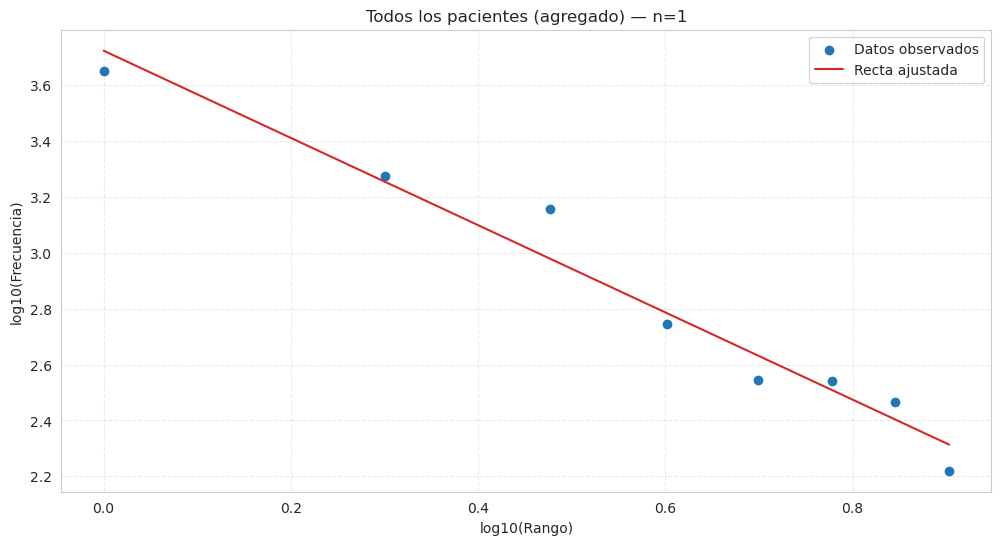


Todos los pacientes (agregado) | n = 2
Total de 2-gramas: 9491
2-gramas únicos: 47
Pendiente (−β): -2.2602
Intercepto (log10(k)): 4.2319
R²: 0.8525


,Rango,Representación,Frecuencia,Probabilidad,log10(Rango),log10(Frecuencia)
0,1,2→2,3966,0.417870,0.000000,3.598353
1,2,5→5,1781,0.187651,0.301030,3.250664
2,3,4→4,1274,0.134232,0.477121,3.105169
3,4,0→0,240,0.025287,0.602060,2.380211
4,5,2→3,223,0.023496,0.698970,2.348305
5,6,3→3,222,0.023391,0.778151,2.346353
6,7,3→2,169,0.017806,0.845098,2.227887
7,8,7→7,159,0.016753,0.903090,2.201397
8,9,3→4,144,0.015172,0.954243,2.158362
9,10,1→1,137,0.014435,1.000000,2.136721


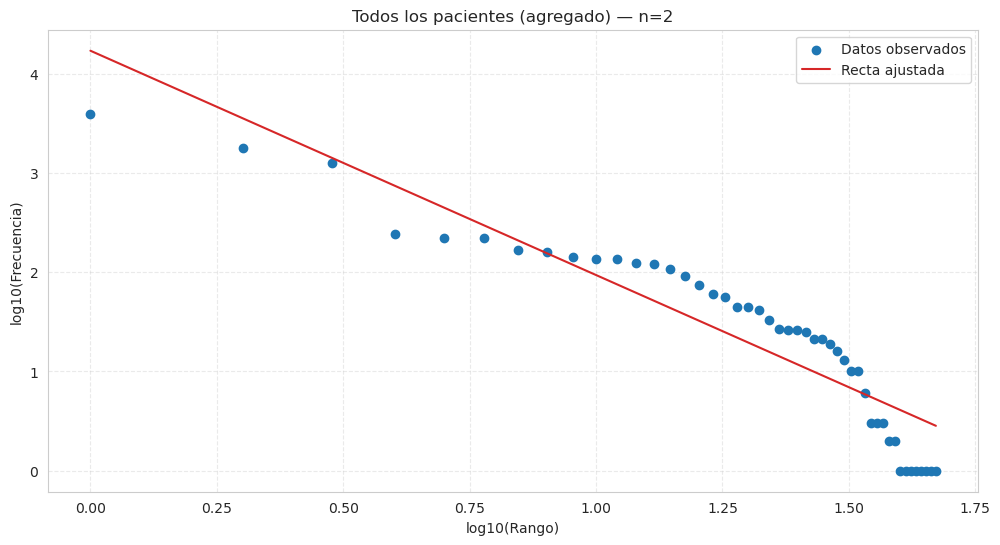


Todos los pacientes (agregado) | n = 5
Total de 5-gramas: 9461
5-gramas únicos: 707
Pendiente (−β): -1.1792
Intercepto (log10(k)): 3.2157
R²: 0.9689


,Rango,Representación,Frecuencia,Probabilidad,log10(Rango),log10(Frecuencia)
0,1,2→2→2→2→2,2972,0.314132,0.000000,3.473049
1,2,5→5→5→5→5,1515,0.160131,0.301030,3.180413
2,3,4→4→4→4→4,1010,0.106754,0.477121,3.004321
3,4,7→7→7→7→7,143,0.015115,0.602060,2.155336
4,5,0→0→0→0→0,123,0.013001,0.698970,2.089905
5,6,2→2→2→2→3,114,0.012049,0.778151,2.056905
6,7,2→2→2→2→6,104,0.010992,0.845098,2.017033
7,8,6→2→2→2→2,94,0.009936,0.903090,1.973128
8,9,1→2→2→2→2,90,0.009513,0.954243,1.954243
9,10,2→2→2→3→2,84,0.008879,1.000000,1.924279


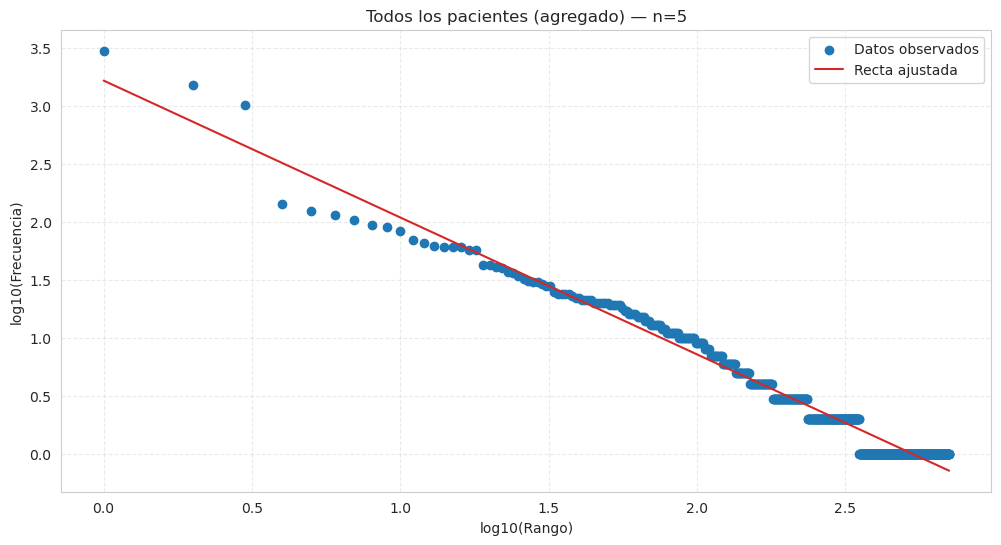


Todos los pacientes (agregado) | n = 6
Total de 6-gramas: 9451
6-gramas únicos: 1096
Pendiente (−β): -1.0033
Intercepto (log10(k)): 2.8806
R²: 0.9456


,Rango,Representación,Frecuencia,Probabilidad,log10(Rango),log10(Frecuencia)
0,1,2→2→2→2→2→2,2714,0.287165,0.000000,3.433610
1,2,5→5→5→5→5→5,1432,0.151518,0.301030,3.155943
2,3,4→4→4→4→4→4,949,0.100413,0.477121,2.977266
3,4,7→7→7→7→7→7,138,0.014602,0.602060,2.139879
4,5,0→0→0→0→0→0,106,0.011216,0.698970,2.025306
5,6,2→2→2→2→2→3,102,0.010793,0.778151,2.008600
6,7,2→2→2→2→2→6,94,0.009946,0.845098,1.973128
7,8,1→2→2→2→2→2,85,0.008994,0.903090,1.929419
8,9,6→2→2→2→2→2,85,0.008994,0.954243,1.929419
9,10,2→2→2→2→3→2,75,0.007936,1.000000,1.875061


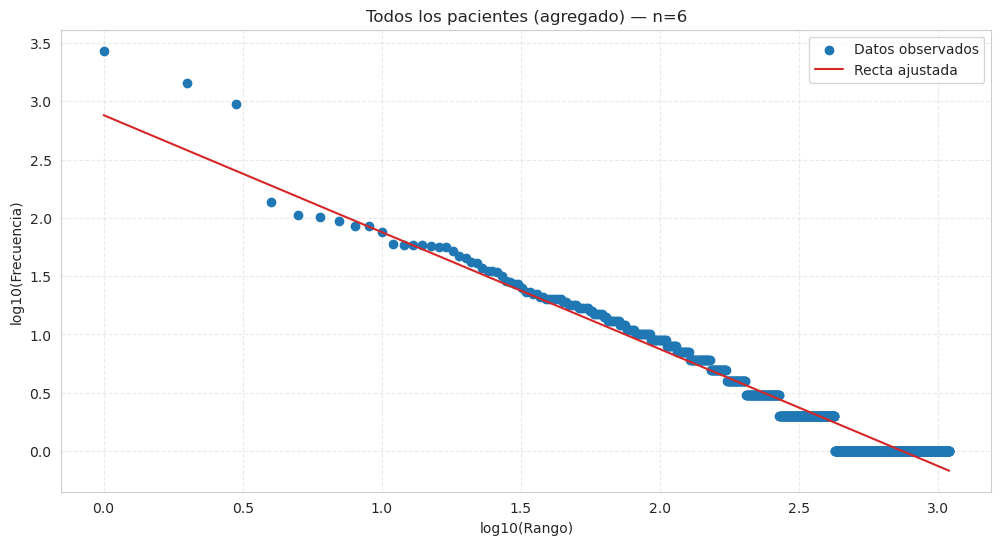


Todos los pacientes (agregado) | n = 10
Total de 10-gramas: 9411
10-gramas únicos: 2664
Pendiente (−β): -0.6272
Intercepto (log10(k)): 1.9904
R²: 0.7943


,Rango,Representación,Frecuencia,Probabilidad,log10(Rango),log10(Frecuencia)
0,1,2→2→2→2→2→2→2→2→2→2,1900,0.201891,0.000000,3.278754
1,2,5→5→5→5→5→5→5→5→5→5,1147,0.121879,0.301030,3.059563
2,3,4→4→4→4→4→4→4→4→4→4,776,0.082457,0.477121,2.889862
3,4,7→7→7→7→7→7→7→7→7→7,121,0.012857,0.602060,2.082785
4,5,2→2→2→2→2→2→2→2→2→6,71,0.007544,0.698970,1.851258
5,6,2→2→2→2→2→2→2→2→2→3,68,0.007226,0.778151,1.832509
6,7,1→2→2→2→2→2→2→2→2→2,64,0.006801,0.845098,1.806180
7,8,0→0→0→0→0→0→0→0→0→0,62,0.006588,0.903090,1.792392
8,9,6→2→2→2→2→2→2→2→2→2,60,0.006376,0.954243,1.778151
9,10,2→2→2→2→2→2→2→2→3→2,52,0.005525,1.000000,1.716003


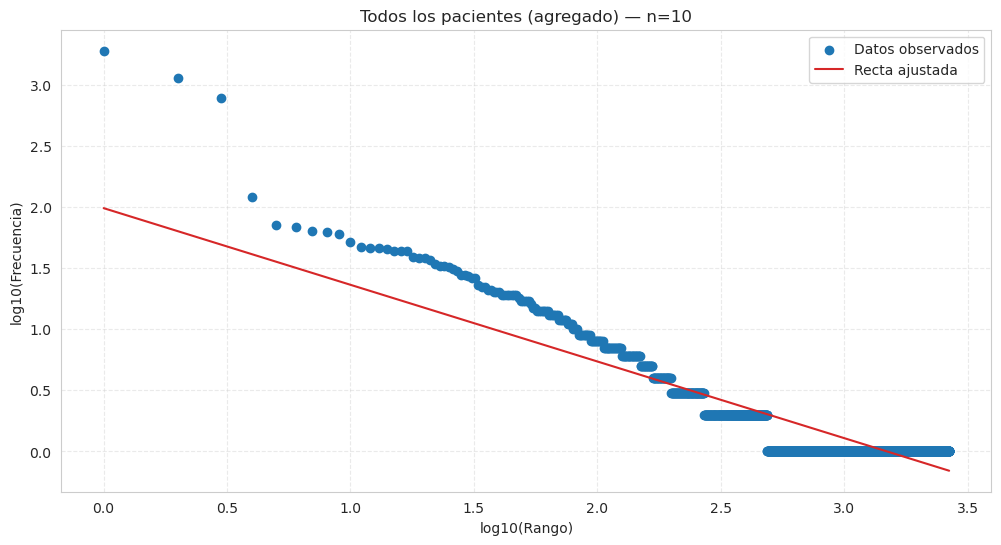


Todos los pacientes (agregado) | n = 15
Total de 15-gramas: 9361
15-gramas únicos: 4185
Pendiente (−β): -0.4445
Intercepto (log10(k)): 1.4842
R²: 0.6673


,Rango,Representación,Frecuencia,Probabilidad,log10(Rango),log10(Frecuencia)
0,1,2→2→2→2→2→2→2→2→2→2→2→2→2→2→2,1258,0.134387,0.000000,3.099681
1,2,5→5→5→5→5→5→5→5→5→5→5→5→5→5→5,891,0.095182,0.301030,2.949878
2,3,4→4→4→4→4→4→4→4→4→4→4→4→4→4→4,630,0.067301,0.477121,2.799341
3,4,7→7→7→7→7→7→7→7→7→7→7→7→7→7→7,101,0.010789,0.602060,2.004321
4,5,2→2→2→2→2→2→2→2→2→2→2→2→2→2→3,48,0.005128,0.698970,1.681241
5,6,2→2→2→2→2→2→2→2→2→2→2→2→2→2→6,42,0.004487,0.778151,1.623249
6,7,1→2→2→2→2→2→2→2→2→2→2→2→2→2→2,41,0.004380,0.845098,1.612784
7,8,6→2→2→2→2→2→2→2→2→2→2→2→2→2→2,40,0.004273,0.903090,1.602060
8,9,0→0→0→0→0→0→0→0→0→0→0→0→0→0→0,39,0.004166,0.954243,1.591065
9,10,2→2→2→2→6→2→2→2→2→2→2→2→2→2→2,36,0.003846,1.000000,1.556303


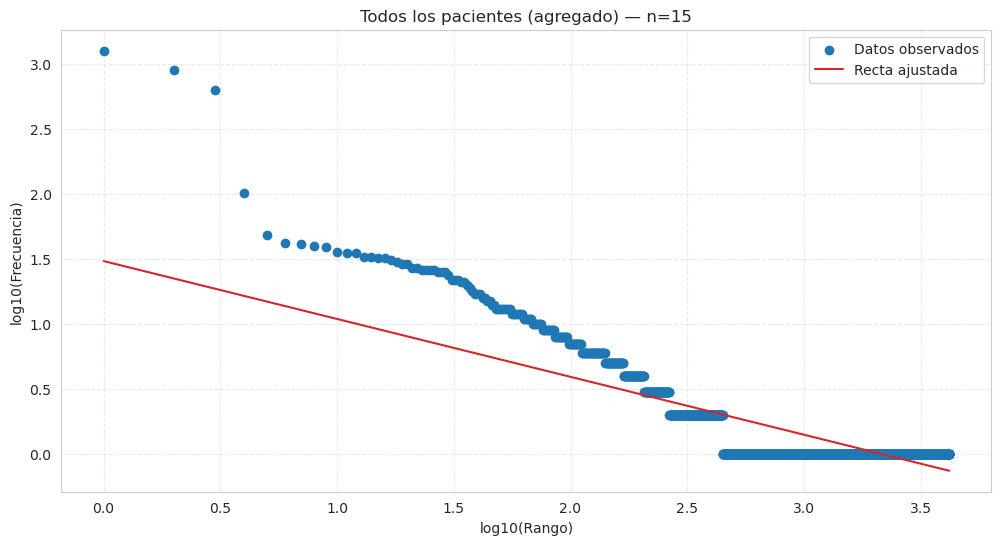


Todos los pacientes (agregado) | n = 20
Total de 20-gramas: 9311
20-gramas únicos: 5316
Pendiente (−β): -0.3460
Intercepto (log10(k)): 1.1867
R²: 0.5921


,Rango,Representación,Frecuencia,Probabilidad,log10(Rango),log10(Frecuencia)
0,1,2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2,848,0.091075,0.000000,2.928396
1,2,5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5,697,0.074858,0.301030,2.843233
2,3,4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4,536,0.057566,0.477121,2.729165
3,4,7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7,86,0.009236,0.602060,1.934498
4,5,2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→3,32,0.003437,0.698970,1.505150
5,6,2→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5,29,0.003115,0.778151,1.462398
6,7,0→0→0→0→0→0→0→0→0→0→0→0→0→0→0→0→0→0→0→0,28,0.003007,0.845098,1.447158
7,8,2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→6,26,0.002792,0.903090,1.414973
8,9,2→2→2→2→2→2→2→2→6→2→2→2→2→2→2→2→2→2→2→2,26,0.002792,0.954243,1.414973
9,10,1→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2,26,0.002792,1.000000,1.414973


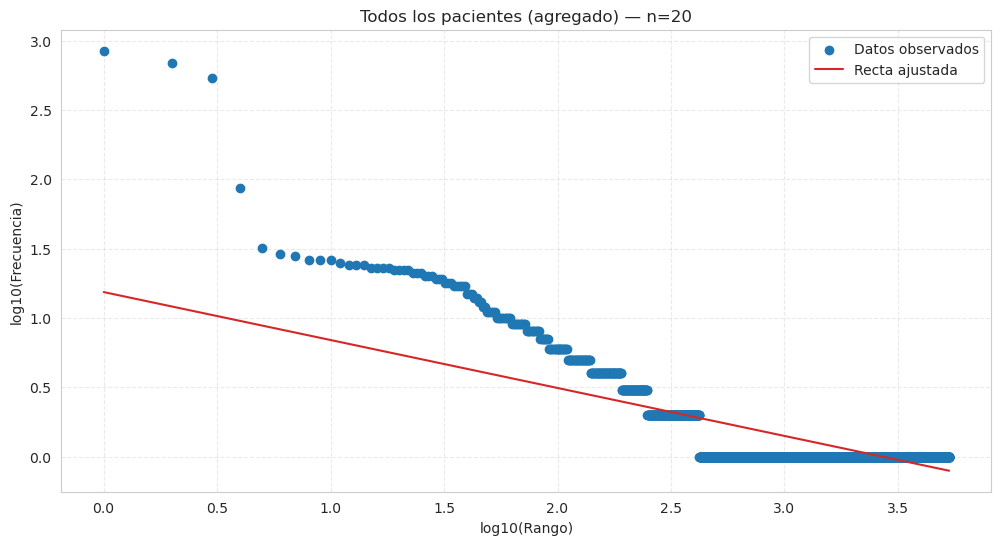


Todos los pacientes (agregado) | n = 25
Total de 25-gramas: 9261
25-gramas únicos: 6158
Pendiente (−β): -0.2824
Intercepto (log10(k)): 0.9841
R²: 0.5362


,Rango,Representación,Frecuencia,Probabilidad,log10(Rango),log10(Frecuencia)
0,1,2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2,575,0.062088,0.000000,2.759668
1,2,5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5,536,0.057877,0.301030,2.729165
2,3,4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4,462,0.049887,0.477121,2.664642
3,4,7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7,72,0.007775,0.602060,1.857332
4,5,2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→3,24,0.002592,0.698970,1.380211
5,6,2→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5,22,0.002376,0.778151,1.342423
6,7,1→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2,21,0.002268,0.845098,1.322219
7,8,2→2→2→2→2→2→2→2→2→2→2→2→2→6→2→2→2→2→2→2→2→2→2→2→2,18,0.001944,0.903090,1.255273
8,9,2→2→2→2→2→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5,18,0.001944,0.954243,1.255273
9,10,2→2→2→2→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5,18,0.001944,1.000000,1.255273


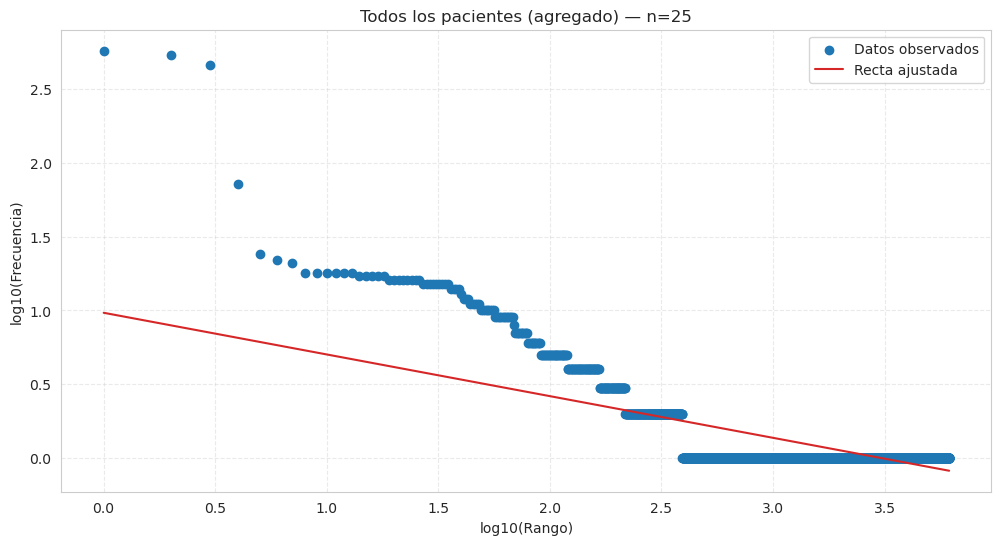


Todos los pacientes (agregado) | n = 35
Total de 35-gramas: 9161
35-gramas únicos: 7331
Pendiente (−β): -0.1971
Intercepto (log10(k)): 0.6996
R²: 0.4543


,Rango,Representación,Frecuencia,Probabilidad,log10(Rango),log10(Frecuencia)
0,1,4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→...,332,0.036241,0.000000,2.521138
1,2,5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→...,291,0.031765,0.301030,2.463893
2,3,2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→...,247,0.026962,0.477121,2.392697
3,4,7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→...,61,0.006659,0.602060,1.785330
4,5,2→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→...,18,0.001965,0.698970,1.255273
5,6,2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→...,16,0.001747,0.778151,1.204120
6,7,2→2→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→...,15,0.001637,0.845098,1.176091
7,8,2→2→2→2→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→...,14,0.001528,0.903090,1.146128
8,9,2→2→2→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→...,14,0.001528,0.954243,1.146128
9,10,3→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→...,13,0.001419,1.000000,1.113943


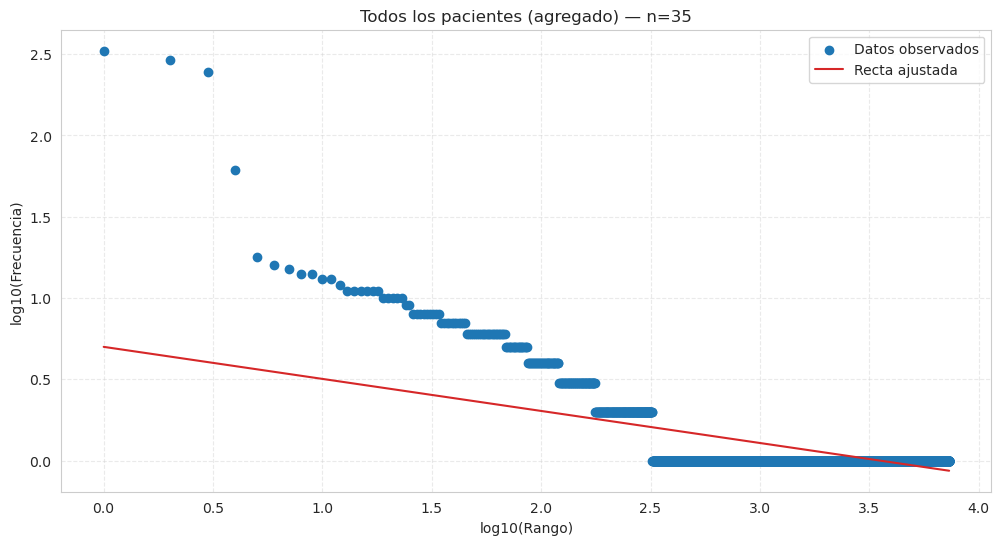


Todos los pacientes (agregado) | n = 50
Total de 50-gramas: 9011
50-gramas únicos: 8322
Pendiente (−β): -0.1002
Intercepto (log10(k)): 0.3594
R²: 0.3123


,Rango,Representación,Frecuencia,Probabilidad,log10(Rango),log10(Frecuencia)
0,1,4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→...,158,0.017534,0.000000,2.198657
1,2,5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→...,92,0.010210,0.301030,1.963788
2,3,2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→2→...,67,0.007435,0.477121,1.826075
3,4,7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→7→...,46,0.005105,0.602060,1.662758
4,5,3→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→...,10,0.001110,0.698970,1.000000
5,6,2→2→2→2→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→...,7,0.000777,0.778151,0.845098
6,7,2→2→2→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→...,7,0.000777,0.845098,0.845098
7,8,2→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→...,7,0.000777,0.903090,0.845098
8,9,3→3→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→4→...,6,0.000666,0.954243,0.778151
9,10,2→2→2→2→2→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→5→...,6,0.000666,1.000000,0.778151


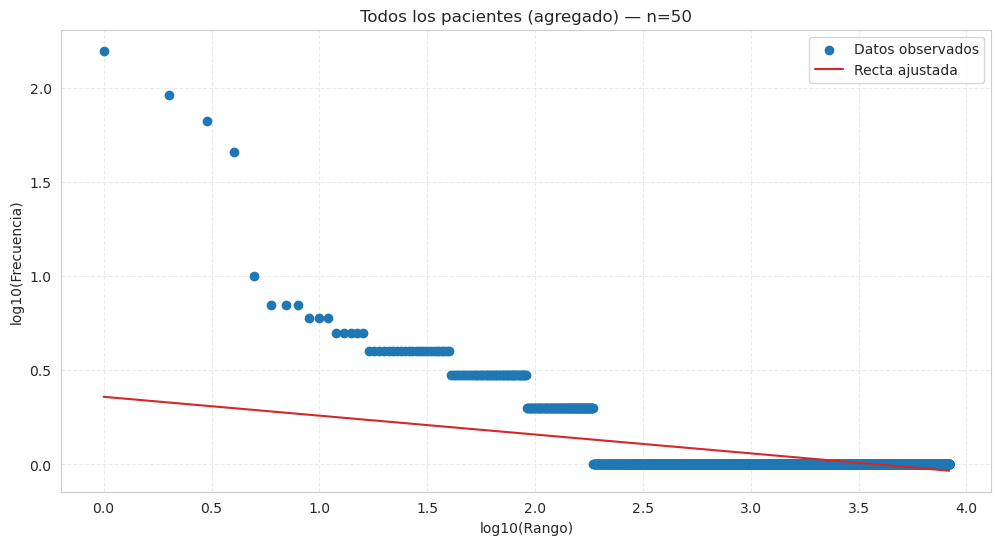


Todos los pacientes (agregado) | n = 100
Total de 100-gramas: 8511
100-gramas únicos: 8511
Pendiente (−β): 0.0000
Intercepto (log10(k)): 0.0000
R²: no disponible


,Rango,Representación,Frecuencia,Probabilidad,log10(Rango),log10(Frecuencia)
0,1,7→7→7→7→7→7→7→7→7→7→7→7→7→7→0→6→0→0→0→0→0→0→1→...,1,0.000117,0.000000,0.0
1,2,7→7→7→7→7→7→7→7→7→7→7→7→7→0→6→0→0→0→0→0→0→1→1→...,1,0.000117,0.301030,0.0
2,3,7→7→7→7→7→7→7→7→7→7→7→7→0→6→0→0→0→0→0→0→1→1→2→...,1,0.000117,0.477121,0.0
3,4,7→7→7→7→7→7→7→7→7→7→7→0→6→0→0→0→0→0→0→1→1→2→2→...,1,0.000117,0.602060,0.0
4,5,7→7→7→7→7→7→7→7→7→7→0→6→0→0→0→0→0→0→1→1→2→2→2→...,1,0.000117,0.698970,0.0
5,6,7→7→7→7→7→7→7→7→7→0→6→0→0→0→0→0→0→1→1→2→2→2→2→...,1,0.000117,0.778151,0.0
6,7,7→7→7→7→7→7→7→7→0→6→0→0→0→0→0→0→1→1→2→2→2→2→2→...,1,0.000117,0.845098,0.0
7,8,7→7→7→7→7→7→7→0→6→0→0→0→0→0→0→1→1→2→2→2→2→2→2→...,1,0.000117,0.903090,0.0
8,9,7→7→7→7→7→7→0→6→0→0→0→0→0→0→1→1→2→2→2→2→2→2→2→...,1,0.000117,0.954243,0.0
9,10,7→7→7→7→7→0→6→0→0→0→0→0→0→1→1→2→2→2→2→2→2→2→2→...,1,0.000117,1.000000,0.0


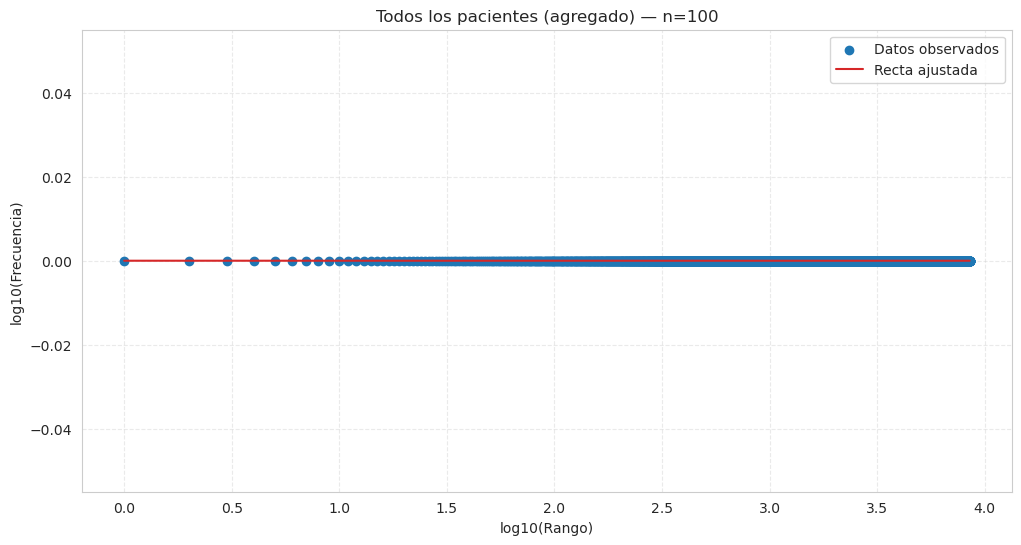

In [54]:
# Ejemplo: análisis agregado de todos los pacientes disponibles
resultados_agregados = analizar_todos_pacientes(lista_n=(1, 2, 5, 6, 10, 15, 20, 25, 35, 50, 100))

### Interpretación rápida

- Una pendiente cercana a **−1** indica comportamiento tipo Zipf (ley de potencia clásica).
- Valores de **R²** altos (≥0.9) sugieren un ajuste lineal sólido en escala log-log.
- Al incrementar **n**, vigila en qué punto el ajuste pierde linealidad (caída de **R²** o cambio drástico de la pendiente). Ese momento marca cuándo el comportamiento tipo lenguaje se desvanece para los hipnogramas.


### Análisis agregado por valores de n

| n | Total de n-gramas | n-gramas únicos | Pendiente (-β) |   R²   | Lectura rápida                                                                      |
|---|-------------------|-----------------|----------------|--------|-------------------------------------------------------------------------------------|
| 1 | 9501              |          8      |     -1.5618    | 0.9637 | Distribución muy estable, etapas aisladas con claro orden jerárquico.               |
| 2 | 9491              |         47      |     -2.2602    | 0.8525 | Caída más pronunciada, pero aún con ley de potencia visible.                        |
| 5 | 9461              |        707      |     -1.1792    | 0.9689 | Perfil casi Zipfiano; la cola larga mantiene el ajuste.                             |
| 6 | 9451              |       1096      |     -1.0033    | 0.9456 | Pendiente casi ideal (**≈ -1**); muy buen candidato para embeddings de secuencias.  |
|10 | 9411              |       2664      |     -0.6272    | 0.7943 | Ajuste consistente aunque menos lineal; se preserva estructura lingüística.         |
|15 | 9361              |       4185      |     -0.4445    | 0.6673 | Inicio de degradación: recta se separa de los datos y la pendiente se aplana.       |
|20 | 9311              |       5316      |     -0.3460    | 0.5921 | Ley de potencia débil; aparecen mesetas en la distribución.                         |
|25 | 9261              |       6158      |     -0.2824    | 0.5362 | Tendencia casi plana; el modelo deja de describir bien la cola.                     |
|35 | 9161              |       7331      |     -0.1971    | 0.4543 | La linealidad se pierde; frecuencias similares para muchos símbolos.                |
|50 | 9011              |       8322      |     -0.1002    | 0.3123 | Colapso del ajuste: predominan repeticiones largas y pocas secuencias distintas.    |
|100| 8511              |       8511      |     0.0000     |   s/d  | Cada secuencia es única; ya no existe estructura repetida que pueda modelarse.      |

**Conclusiones clave:**
- El comportamiento tipo ley de potencia se mantiene robusto hasta **n ≈ 10** (pendientes entre -1.5 y -0.6, R² > 0.79).
- A partir de **n = 15** la pendiente se acerca a cero y **R²** cae por debajo de 0.7: la relación rango-frecuencia deja de ser lineal en log-log.
- Desde **n = 25** en adelante la distribución es prácticamente plana; los n-gramas largos son raros y casi todos distintos.
- **n = 100** evidencia el límite: no hay repeticiones y cualquier intento de ley de potencia deja de tener sentido estadístico.